# Cleaning

Let's make a columns for emojis and its corresponding tweets

In [93]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
from collections import Counter
import re
import nltk
import nltk.tokenize as tk
import en_core_web_sm
import string
nltk.download('stopwords')

# complete list of emojis
from emoji import UNICODE_EMOJI

from nltk.corpus import stopwords

nlp = en_core_web_sm.load()

stopwords = stopwords.words('english')

stopwords.extend(['\'s','’s','rt','…','️','...','follow', 'dm', 'https', 'ur', 'll' ,'amp', 'subscribe', 'don', 've', 'retweet', 'im', 'http'])

punctuations = string.punctuation

letters = '🇦 🇧 🇨 🇩 🇪 🇫 🇬 🇭 🇮 🇯 🇰 🇱 🇲 🇳 🇴 🇵 🇶 🇷 🇸 🇹 🇺 🇻 🇼 🇽 🇾 🇿'.split()

import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

class clean_tweets(object):
    def __init__(self): 
        #self.tweets = list(pickle.load(open('./data/yay_moji.pkl','rb')))
        self.mojis = pd.read_pickle('./data/df_emoji.pkl')
        self.flags = self.mojis['unichar'][1458:]
        self.emojis = list(UNICODE_EMOJI.keys())
        
    def cleanup_text(self, tweets, logging=False):

        '''
        Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
        '''
        texts = []
        counter = 1
        for tweet in tweets:
            if counter % 1000 == 0 and logging:
                print("Processed %d out of %d documents." % (counter, len(tweets)))
            counter += 1
            doc = nlp(tweet, disable=['parser', 'ner'])
            tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
            tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
            tokens = ' '.join(tokens)
            tokens = re.sub('@[^\s]+','', tokens)
            texts.append(tokens)
        return(pd.Series(texts))
    

    def fix_flags(self, tweets):
        '''
        change letter emojis to flags
        '''
        tweets = self.cleanup_text(tweets)
        
        fixed = []
        for tweet in tweets:
            for l in letters:
                if l in tweet:
                    tweet = re.sub(l+" ", l, tweet)
            fixed.append(tweet)
        return(fixed)
    
    
    def flags_space(self, tweets):
        '''
        put space after flag emojis
        '''
        tweets = self.fix_flags(tweets)
        
        fixed = []
        for tweet in tweets:
            for l in self.flags:
                if l in tweet:
                    tweet = re.sub(l, l+" ", tweet)
            fixed.append(tweet)
        return(fixed)
    
    def extract_remove_mojis(self, tweets):
        
        tweets = self.flags_space(tweets)
        
        # extracting emojis
    
        emoji = defaultdict(list)

        for i, tweet in enumerate(tweets):
            for word in tweet.split():
                if word in self.emojis:
                    emoji['emoji'].append(word)
                    emoji['index'].append(i)

        # delete overlapping emojis in a tweet
        emoji = pd.DataFrame(emoji).drop_duplicates()

        # remove emojis
        
        no_emojis = []

        for tweet in tweets:
            tweet = tweet.split()
            words = []

            for word in tweet:
                if word not in list(extracted['emoji']):
                    words.append(word)
            words = ' '.join(words)
            no_emojis.append(words)
            
        return(emoji, no_emojis)
    
    def tweets_df(self, tweets):
    
        extracted, tw_no_emo = self.extract_remove_mojis(tweets)

        tweets_df = pd.DataFrame(tw_no_emo, columns = ['tweets'])

        tweets_merged = pd.merge(extracted, tweets_df.reset_index(), on='index', how='left')
        
        return(tweets_merged)
    
    def top_emojis(self, tweets_df):
        # show top 25 most frequently occuring emojis
        tw = [word for word in tweets_df['emoji']]
        tw_counts = Counter(tw)
        tw_common_words = [word[0] for word in tw_counts.most_common(25)]
        tw_common_counts = [word[1] for word in tw_counts.most_common(25)]
        print(pd.DataFrame([tw_common_words,tw_common_counts]))
    
    def top_words(self, tweets_df):
        # Plot top 25 most frequently occuring words
        tw = [word for word in tweets_df['tweets']]
        tw = ' '.join(tw).split()
        tw_counts = Counter(tw)
        tw_common_words = [word[0] for word in tw_counts.most_common(25)]
        tw_common_counts = [word[1] for word in tw_counts.most_common(25)]
        plt.figure(figsize=(15, 12))
        sns.barplot(x=tw_common_words, y=tw_common_counts)
        plt.show()

[nltk_data] Downloading package stopwords to /Users/sara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
cleaning = clean_tweets()

In [95]:
tweets = list(pickle.load(open('./data/yay_moji.pkl','rb')))
tweets_df = cleaning.tweets_df(tweets)

In [84]:
cleaning.top_emojis(tweets_df)

    0    1    2    3    4    5    6    7    8    9   ...   15   16  17  18  \
0    😂   🇺🇸    🤯    ❤    😭    😍    ✨    🔥    🙊    🤣  ...    💕    🤔   🙌   🤷   
1  851  452  413  385  378  340  321  272  214  182  ...  106  103  99  97   

   19  20  21  22  23  24  
0   😊   👏   👍   🚨   👀   💙  
1  97  96  95  93  91  88  

[2 rows x 25 columns]


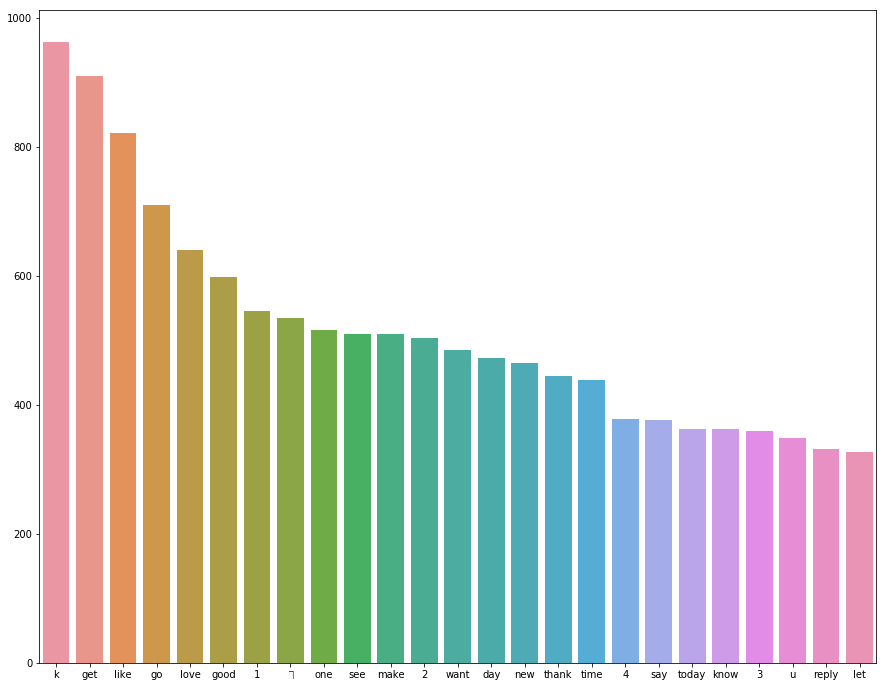

In [85]:
cleaning.top_words(tweets_df)

In [50]:
# emojis with at least 10 tweets
enough_emoji = tweets_merged.groupby('emoji').count()[tweets_merged.groupby('emoji').count()['tweets']>=10]
enough_emoji = pd.merge(enough_emoji.reset_index()[['emoji']], tweets_merged, on='emoji', how='left')